Remenber to set the spark version correctly. Here I used spark-2.4.7
Find a version available on this site: https://downloads.apache.org/spark/

###Set up spark environment

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, TimestampType, IntegerType
from pyspark.sql.functions import to_date

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

###Import and Explore Dataset

In [7]:
spark = SparkSession \
    .builder \
    .appName('Ruoyuan\'s Python Spark Notebook') \
    .getOrCreate()
print(spark.version)  
sc = spark.sparkContext

2.4.7


In [8]:
!wget https://raw.githubusercontent.com/ruoyuanDu/Online_sales-RFM/main/online_retail_II.csv

--2021-01-06 17:34:52--  https://raw.githubusercontent.com/ruoyuanDu/Online_sales-RFM/main/online_retail_II.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88896544 (85M) [text/plain]
Saving to: ‘online_retail_II.csv’

online_retail_II.cs 100%[===================>]  84.78M   167MB/s    in 0.5s    

2021-01-06 17:34:56 (167 MB/s) - ‘online_retail_II.csv’ saved [88896544/88896544]



In [64]:
raw_data = spark.read.csv('online_retail_II.csv', header = True)
raw_data.show()

+-------+---------+--------------------+--------+--------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|   InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+--------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|12/1/2009 7:45| 6.95|      13085|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|12/1/2009 7:45| 6.75|      13085|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|12/1/2009 7:45| 6.75|      13085|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|12/1/2009 7:45|  2.1|      13085|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|12/1/2009 7:45| 1.25|      13085|United Kingdom|
| 489434|    22064|PINK DOUGHNUT TRI...|      24|12/1/2009 7:45| 1.65|      13085|United Kingdom|
| 489434|    21871| SAVE THE PLANET MUG|      24|12/1/2009 7:45| 1.25|      13085|United Kingdom|
| 489434|    21523|F

In [65]:
# import dataset as panas dataframe for ease to make plots
raw_data_df = pd.read_csv('online_retail_II.csv')

In [11]:
raw_data.count()

1067371

In [12]:
raw_data.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Country: string (nullable = true)



### Check if any outliers and unusual values are in the dataset

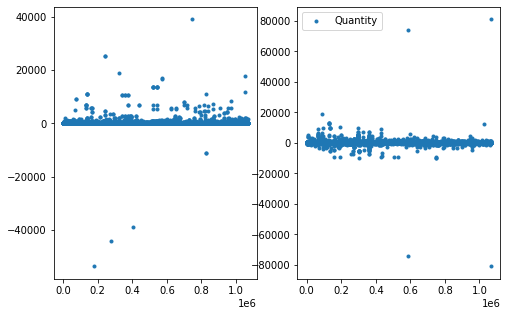

In [14]:
figure, axes = plt.subplots(1,2,sharex=False, sharey=False, figsize=(8, 5),squeeze=True)
axes[0].plot(raw_data_df['Price'], '.', label = 'Price')
axes[1].plot(raw_data_df['Quantity'], '.', label='Quantity')
plt.legend()
plt.show()

Price and quantity values cannot be negative, so we need to remove negative points

### Data Clean up

pyspark dataframe: change column data types

In [15]:
raw_data = raw_data.withColumn('Quantity', raw_data.Quantity.cast(IntegerType()))\
                   .withColumn('Price', raw_data.Price.cast(DoubleType()))\
                   .withColumn('InvoiceDate', to_date('InvoiceDate', 'MM/dd/yyyy H:m'))

In [16]:
raw_data.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Country: string (nullable = true)



In [17]:
raw_data.show()

+-------+---------+--------------------+--------+-----------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-----------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12| 2009-12-01| 6.95|      13085|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12| 2009-12-01| 6.75|      13085|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12| 2009-12-01| 6.75|      13085|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48| 2009-12-01|  2.1|      13085|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24| 2009-12-01| 1.25|      13085|United Kingdom|
| 489434|    22064|PINK DOUGHNUT TRI...|      24| 2009-12-01| 1.65|      13085|United Kingdom|
| 489434|    21871| SAVE THE PLANET MUG|      24| 2009-12-01| 1.25|      13085|United Kingdom|
| 489434|    21523|FANCY FONT HOME S...|      10| 

**Drop rows with null values** 

In [18]:
clean_raw_data = raw_data.filter(raw_data['Invoice'].isNotNull())\
                         .filter(raw_data['InvoiceDate'].isNotNull())\
                         .filter(raw_data['Price'].isNotNull())\
                         .filter(raw_data['Quantity'].isNotNull())\
                         .filter(raw_data['Customer ID'].isNotNull())

In [19]:
clean_raw_data.count()

824364

**Drop negative price and quantity values**  

In [20]:
clean_raw_data.filter(F.col('Quantity')<0).count()

18744

In [21]:
clean_raw_data.filter(F.col('Price')<0).count()

0

In [22]:
clean_raw_data = clean_raw_data.filter(F.col('Quantity')>=0)

In [23]:
clean_raw_data.count()

805620

**Group by customer ID and calculate the sum of total values spent by each customer, find their most recent purchase, and total number of purchases have been made**  

In [24]:
clean_raw_data_agg = clean_raw_data.groupBy('Customer ID').agg(F.round(F.sum(F.col('Quantity')*F.col('Price')),3).alias('Total expense'),
                                                               F.countDistinct(F.col('Invoice')).alias('Total number of purchases'),
                                                               F.max('InvoiceDate').alias('Most recent purchase'))


In [25]:
clean_raw_data_agg.show()

+-----------+-------------+-------------------------+--------------------+
|Customer ID|Total expense|Total number of purchases|Most recent purchase|
+-----------+-------------+-------------------------+--------------------+
|      12847|       1636.9|                        2|          2011-11-17|
|      13610|      2175.88|                       14|          2011-11-27|
|      15555|     12112.35|                       36|          2011-11-27|
|      13192|      2558.58|                        6|          2011-09-05|
|      15574|       1518.7|                        6|          2011-06-15|
|      15634|       554.65|                        2|          2011-11-22|
|      14157|      1002.78|                        5|          2011-11-20|
|      15271|      4709.54|                       24|          2011-12-02|
|      17686|      8296.81|                        9|          2011-12-02|
|      13865|       501.56|                        4|          2011-10-12|
|      16250|       791.3

In [26]:
clean_raw_data_agg.agg(F.max('Total expense')).show()

+------------------+
|max(Total expense)|
+------------------+
|         608821.65|
+------------------+



In [27]:
clean_raw_data_agg.sort('Total expense', ascending=False).show()

+-----------+-------------+-------------------------+--------------------+
|Customer ID|Total expense|Total number of purchases|Most recent purchase|
+-----------+-------------+-------------------------+--------------------+
|      18102|    608821.65|                      145|          2011-12-09|
|      14646|    528602.52|                      152|          2011-12-08|
|      14156|    313946.37|                      156|          2011-11-30|
|      14911|    295972.63|                      398|          2011-12-08|
|      17450|    246973.09|                       51|          2011-12-01|
|      13694|    196482.81|                      143|          2011-12-06|
|      17511|    175603.55|                       60|          2011-12-07|
|      16446|     168472.5|                        2|          2011-12-09|
|      16684|    147142.77|                       55|          2011-12-05|
|      12415|    144458.37|                       28|          2011-11-15|
|      15061|    137818.5

**From the table above, some of the total expense is much larger than the rest values, we need further check those extrem values**  

**Convert pyspark dataframe to pandas dataframe so that we can visually check outliers**  

In [28]:
clean_raw_data_agg_df = clean_raw_data_agg.toPandas()


### Check Outliers

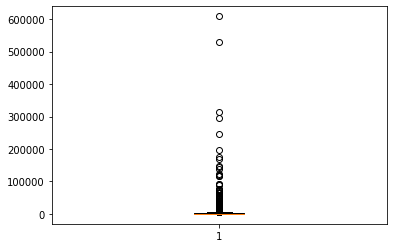

In [29]:
plt.boxplot(clean_raw_data_agg_df['Total expense'])
plt.show()

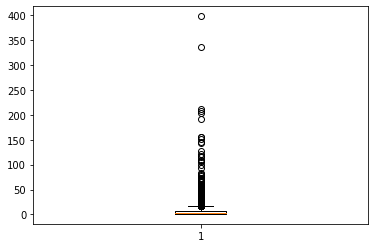

In [30]:
plt.boxplot(clean_raw_data_agg_df['Total number of purchases'])
plt.show()

### Using Inter quantile range method to determine outliers

In [31]:
# Define a function to calculate upper and lower bounds using inter quantile range method
def iqr_bound(dataframe, columns):
  '''columns must be in the form of a list'''
  bounds = dict()
  for c in columns:
    bounds[c] = dict(zip(['q1', 'q3'], dataframe.approxQuantile(c, [0.25, 0.75], 0)))
    iqr = bounds[c]['q3']-bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1']-iqr*1.5
    bounds[c]['upper'] = bounds[c]['q3']+iqr*1.5
  return bounds

In [32]:
bounds = iqr_bound(clean_raw_data_agg, ['Total expense','Total number of purchases'])

In [33]:
bounds

{'Total expense': {'lower': -2586.7699999999995,
  'q1': 347.8,
  'q3': 2304.18,
  'upper': 5238.75},
 'Total number of purchases': {'lower': -8.0,
  'q1': 1.0,
  'q3': 7.0,
  'upper': 16.0}}

Even though there are many values are byond upper bounds of Total expense and total number of purchases, these values cannot be deleted as outliers easily because no evidense showing their irrationality.

To examine how these values can affect our model, we'd like to create two dataframes, with and without values beyond upper bounds.

In [34]:
clean_data_agg_without_outliers = clean_raw_data_agg.withColumn('outlier_total_expense',F.when((F.col('Total expense')<bounds['Total expense']['lower'])|(F.col('Total expense')>bounds['Total expense']['upper']), 1)\
                                                   .otherwise(0))

In [35]:
clean_data_agg_without_outliers.show()

+-----------+-------------+-------------------------+--------------------+---------------------+
|Customer ID|Total expense|Total number of purchases|Most recent purchase|outlier_total_expense|
+-----------+-------------+-------------------------+--------------------+---------------------+
|      12847|       1636.9|                        2|          2011-11-17|                    0|
|      13610|      2175.88|                       14|          2011-11-27|                    0|
|      15555|     12112.35|                       36|          2011-11-27|                    1|
|      13192|      2558.58|                        6|          2011-09-05|                    0|
|      15574|       1518.7|                        6|          2011-06-15|                    0|
|      15634|       554.65|                        2|          2011-11-22|                    0|
|      14157|      1002.78|                        5|          2011-11-20|                    0|
|      15271|      4709.54|   

In [36]:
clean_data_agg_without_outliers = clean_data_agg_without_outliers.filter(F.col('outlier_total_expense')==0)

In [37]:
clean_data_agg_without_outliers.show()

+-----------+-------------+-------------------------+--------------------+---------------------+
|Customer ID|Total expense|Total number of purchases|Most recent purchase|outlier_total_expense|
+-----------+-------------+-------------------------+--------------------+---------------------+
|      12847|       1636.9|                        2|          2011-11-17|                    0|
|      13610|      2175.88|                       14|          2011-11-27|                    0|
|      13192|      2558.58|                        6|          2011-09-05|                    0|
|      15574|       1518.7|                        6|          2011-06-15|                    0|
|      15634|       554.65|                        2|          2011-11-22|                    0|
|      14157|      1002.78|                        5|          2011-11-20|                    0|
|      15271|      4709.54|                       24|          2011-12-02|                    0|
|      13865|       501.56|   

In [38]:
df  = clean_data_agg_without_outliers.toPandas()

[]

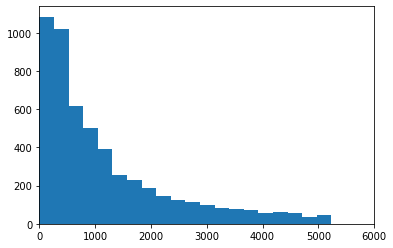

In [39]:
plt.hist(df['Total expense'], bins=20)
plt.xlim([0, 6000])
plt.plot()

#### Calculation of frequency
Date difference

In [40]:
clean_raw_data_agg = clean_raw_data_agg.withColumn('date_difference', F.datediff(to_date(F.lit('2011-12-31')),F.col('Most recent purchase')))

In [41]:
clean_raw_data_agg.show()

+-----------+-------------+-------------------------+--------------------+---------------+
|Customer ID|Total expense|Total number of purchases|Most recent purchase|date_difference|
+-----------+-------------+-------------------------+--------------------+---------------+
|      12847|       1636.9|                        2|          2011-11-17|             44|
|      13610|      2175.88|                       14|          2011-11-27|             34|
|      15555|     12112.35|                       36|          2011-11-27|             34|
|      13192|      2558.58|                        6|          2011-09-05|            117|
|      15574|       1518.7|                        6|          2011-06-15|            199|
|      15634|       554.65|                        2|          2011-11-22|             39|
|      14157|      1002.78|                        5|          2011-11-20|             41|
|      15271|      4709.54|                       24|          2011-12-02|             29|

**Assign groups**

Set up cutoffs by percentile on the amount of money spent:[0.85, 0.7, 0.4, 0]


In [42]:
monetary_cutoffs = clean_raw_data_agg.approxQuantile('Total expense',[0.75, 0.5, 0.25],0)

In [43]:
monetary_cutoffs

[2304.18, 897.62, 347.8]

In [44]:
recency_cutoffs = clean_raw_data_agg.approxQuantile('date_difference', [0.75, 0.5, 0.25], 0)
recency_cutoffs

[401.0, 117.0, 47.0]

In [45]:
frequency_cutoffs = clean_raw_data_agg.approxQuantile('Total number of purchases', [0.75, 0.5,0.25],0)
frequency_cutoffs

[7.0, 3.0, 1.0]

In [46]:
clean_raw_data_agg_levels = clean_raw_data_agg.withColumn('Total_expense_level', 
                              F.when(F.col('Total expense')>monetary_cutoffs[0],1)\
                              .when(F.col('Total expense')>monetary_cutoffs[1],2)\
                              .when(F.col('Total expense')>monetary_cutoffs[2],3)\
                              .otherwise(4))\
                  .withColumn('Recency_level', F.when(F.col('date_difference')<recency_cutoffs[2],1)\
                                                .when(F.col('date_difference')<recency_cutoffs[1],2)\
                                                .when(F.col('date_difference')<recency_cutoffs[0],3)\
                                                .otherwise(4))\
                  .withColumn('Frequency_level',F.when(F.col('Total number of purchases')>frequency_cutoffs[0],1)\
                                                 .when(F.col('Total number of purchases')>frequency_cutoffs[1],2)\
                                                 .when(F.col('Total number of purchases')>frequency_cutoffs[2],3)\
                                                 .otherwise(4))


**Check the number of customers in group R-1, F-1, M-1** 

customers in group 111 are considered to be best customers becuase they made purchase recently, do so often and psend more than other customers.

In [67]:
best_customers = clean_raw_data_agg_levels\
                         .filter(F.col('Total_expense_level')==1)\
                         .filter(F.col('Recency_level')==1)\
                         .filter(F.col('Frequency_level')==1)

In [68]:
best_customers.show()

+-----------+-------------+-------------------------+--------------------+---------------+-------------------+-------------+---------------+
|Customer ID|Total expense|Total number of purchases|Most recent purchase|date_difference|Total_expense_level|Recency_level|Frequency_level|
+-----------+-------------+-------------------------+--------------------+---------------+-------------------+-------------+---------------+
|      15555|     12112.35|                       36|          2011-11-27|             34|                  1|            1|              1|
|      15271|      4709.54|                       24|          2011-12-02|             29|                  1|            1|              1|
|      17686|      8296.81|                        9|          2011-12-02|             29|                  1|            1|              1|
|      17757|      9422.45|                       56|          2011-12-08|             23|                  1|            1|              1|
|      16549|

In [69]:
best_customers.count()

613

**Check the number of customers in group R-1,F-4, M-1 and group R-1, F-4, M-2** 

Customers in these 2 groups are considered to be high-spending new customers。 These are customers who made purchases only once, but very recently and they spend a lot

In [49]:
high_spending_new_customers = clean_raw_data_agg_levels.filter((F.col('Total_expense_level')==2)|(F.col('Total_expense_level')==1))\
                                                       .filter(F.col('Recency_level')==1)\
                                                       .filter((F.col('Frequency_level')==4))

In [70]:
high_spending_new_customers.show()

+-----------+-------------+-------------------------+--------------------+---------------+-------------------+-------------+---------------+
|Customer ID|Total expense|Total number of purchases|Most recent purchase|date_difference|Total_expense_level|Recency_level|Frequency_level|
+-----------+-------------+-------------------------+--------------------+---------------+-------------------+-------------+---------------+
|      17727|      1060.25|                        1|          2011-11-24|             37|                  2|            1|              4|
|      16800|      1201.49|                        1|          2011-11-28|             33|                  2|            1|              4|
|      15195|       3861.0|                        1|          2011-12-07|             24|                  1|            1|              4|
+-----------+-------------+-------------------------+--------------------+---------------+-------------------+-------------+---------------+



In [50]:
high_spending_new_customers.count()

3

**Check the number of customers in group R-1,F-1, M-3 and group R-1, F-1, M-4**   

Customers in these 2 groups are considered to be lowest-spending active loyal customers becuase they made purchases frequencytly and do so often, but spend the least



In [51]:
lowest_spending_loyal_customers = clean_raw_data_agg_levels.filter(((F.col('Total_expense_level')==3)|(F.col('Total_expense_level')==4))&(F.col('Recency_level')==1)&(F.col('Frequency_level')==1))

In [71]:
lowest_spending_loyal_customers.show()

+-----------+-------------+-------------------------+--------------------+---------------+-------------------+-------------+---------------+
|Customer ID|Total expense|Total number of purchases|Most recent purchase|date_difference|Total_expense_level|Recency_level|Frequency_level|
+-----------+-------------+-------------------------+--------------------+---------------+-------------------+-------------+---------------+
|      16668|       862.42|                       13|          2011-11-24|             37|                  3|            1|              1|
|      17114|       808.62|                        8|          2011-12-04|             27|                  3|            1|              1|
|      16500|       843.91|                        9|          2011-12-05|             26|                  3|            1|              1|
|      17988|       489.54|                       14|          2011-11-28|             33|                  3|            1|              1|
+-----------+

In [52]:
lowest_spending_loyal_customers.count()

4

**Check the number of cusotmers in group R4-1-1, 4-1-2, 4-2-1 and 4-2-2** 

This segment consists of those customers that made purchases frequently and spent a lot, but it's been a long time since their last purchase

In [53]:
churned_best_customers = clean_raw_data_agg_levels.filter((F.col('Recency_level')==4)&(F.col('Frequency_level')==1)|(F.col('Frequency_level')==2)&(F.col('Total_expense_level')==1)|(F.col('Total_expense_level')==2))

In [72]:
churned_best_customers.show()

+-----------+-------------+-------------------------+--------------------+---------------+-------------------+-------------+---------------+
|Customer ID|Total expense|Total number of purchases|Most recent purchase|date_difference|Total_expense_level|Recency_level|Frequency_level|
+-----------+-------------+-------------------------+--------------------+---------------+-------------------+-------------+---------------+
|      12847|       1636.9|                        2|          2011-11-17|             44|                  2|            1|              3|
|      13610|      2175.88|                       14|          2011-11-27|             34|                  2|            1|              1|
|      13192|      2558.58|                        6|          2011-09-05|            117|                  1|            3|              2|
|      15574|       1518.7|                        6|          2011-06-15|            199|                  2|            3|              2|
|      14157|

In [54]:
churned_best_customers.count()

1798

### Scaling features before fitting intto Kmeans models

In [55]:
from pyspark.ml import Pipeline

columns = ['Total expense','Total number of purchases', 'date_difference']
assemblers=[VectorAssembler(inputCols=[col], outputCol=col+"_vec") for col in columns]
scalers = [MinMaxScaler(inputCol = col+"_vec", outputCol=col+"_scaled") for col in columns]
pipeline = Pipeline(stages=assemblers+scalers)
scalerModel=pipeline.fit(clean_raw_data_agg_levels)
scaledData=scalerModel.transform(clean_raw_data_agg_levels)

In [56]:
scaledData.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Total expense: double (nullable = true)
 |-- Total number of purchases: long (nullable = false)
 |-- Most recent purchase: date (nullable = true)
 |-- date_difference: integer (nullable = true)
 |-- Total_expense_level: integer (nullable = false)
 |-- Recency_level: integer (nullable = false)
 |-- Frequency_level: integer (nullable = false)
 |-- Total expense_vec: vector (nullable = true)
 |-- Total number of purchases_vec: vector (nullable = true)
 |-- date_difference_vec: vector (nullable = true)
 |-- Total expense_scaled: vector (nullable = true)
 |-- Total number of purchases_scaled: vector (nullable = true)
 |-- date_difference_scaled: vector (nullable = true)



In [57]:
#filtering out unecessary columsn
scaledata = scaledData.select('Customer ID','Total expense','Total number of purchases','date_difference','Total expense_scaled','Total number of purchases_scaled','date_difference_scaled')

In [58]:
scaledata.show()

+-----------+-------------+-------------------------+---------------+--------------------+--------------------------------+----------------------+
|Customer ID|Total expense|Total number of purchases|date_difference|Total expense_scaled|Total number of purchases_scaled|date_difference_scaled|
+-----------+-------------+-------------------------+---------------+--------------------+--------------------------------+----------------------+
|      12847|       1636.9|                        2|             44|[0.00268863631902...|            [0.00251889168765...|  [0.02981029810298...|
|      13610|      2175.88|                       14|             34|[0.00357392021128...|            [0.0327455919395466]|  [0.01626016260162...|
|      15555|     12112.35|                       36|             34|[0.01989474257362...|            [0.08816120906801...|  [0.01626016260162...|
|      13192|      2558.58|                        6|            117|[0.00420251152369...|            [0.0125944584382

### KNN

In [59]:
vecAssembler = VectorAssembler(inputCols=['Total expense_scaled','Total number of purchases_scaled','date_difference_scaled'], outputCol='features')
new_df = vecAssembler.transform(scaledata)

In [73]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans().setK(6).setSeed(1)
kmeans_clf = kmeans.fit(new_df.select('features'))
transformed= kmeans_clf.transform(new_df)


In [74]:
transformed.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  954|
|         3|  933|
|         5|  418|
|         4|   22|
|         2|  456|
|         0| 3098|
+----------+-----+



In [75]:
centers = kmeans_clf.clusterCenters()

In [76]:
centers

[array([0.00590689, 0.01846645, 0.05004059]),
 array([0.00179694, 0.00453876, 0.52303381]),
 array([0.00120512, 0.00307128, 0.69941283]),
 array([0.00241529, 0.0072165 , 0.27398577]),
 array([0.26953976, 0.37623082, 0.0065287 ]),
 array([9.50194292e-04, 8.91856387e-04, 8.92282906e-01])]